Support Vector Data Description
===================================


The problem of *data description* or one-class classification is to make a description of a training set of objects and to detect which (new) objects resemble this training set. 

This has been greatly used in outlier detection, i.e. the detection of uncharacteristic objects from a data set. Furthermore, another possible application of data description is in a classification problem where one of the classes is sampled very well, while the other class is severely undersampled. 

Here, the method proposed by Tax and Duin in 2004. called *Support Vector Data Description* has been implemented. This method obtains a spherically shaped boundary around the complete target set. To minimize the chance of accepting outliers, the volume of this description is minimized. 

The error function to be minimized is defined as:

$$F(R, \mathbf{a}) = R^2$$

with the constraint:

$$\|\Phi(\mathbf{x}_i)-\mathbf{a}\|^2 \le R^2, \hspace{3mm}\forall i,$$

where $\Phi$ defines an implicit mapping of the data into an another (possibly highdimensional) feature space.

To allow the possibility of outliers in the training set, the distance from $\Phi(\mathbf{x}_i)$ to the center $\mathbf{a}$ should not be strictly smaller than $R^2$, but larger distances should be penalized. Therefore, the slack variables $\xi_i \ge 0$ are introduced, so the minimization problem becomes:

$$F(R, \mathbf{a}) = R^2 + C\sum_i{\xi_i}$$
with the constraint which ensures that almost all objectives are within the sphere:

$$\|\Phi(\mathbf{x}_i)-\mathbf{a}\|^2 \le R^2 + \xi_i, \hspace{3mm} \xi_i \ge 0 \hspace{3mm} \forall i.$$


This optimization problem can be solved using the Lagrange multipliers, so the following expression is obtained:

<!--$$L(R,\mathbf{a}, \alpha_i, \gamma_i, \xi_i) = R^2 + C\sum_i{\xi_i} - \sum_i{\alpha_i(R^2 + \xi_i - ({\|\mathbf{x}_i\|}^2 - 2\mathbf{a}\mathbf{x}_i + {\|\mathbf{a}\|}^2))} - \sum_i{\gamma_i\xi_i},$$

where $L$ should be minimized with respect to $R, \mathbf{a}, \xi_i$ and maximized with respect to the Lagrange multipliers $\alpha_i \ge 0$ and $\gamma_i \ge 0$. -->

<!--After setting the partial derivatives to zero and resubstituting the obtained equations into $L$,--> 

$$L = \sum_i{\alpha_i(\Phi(\mathbf{x}_i)\cdot\Phi(\mathbf{x}_i))} -  \sum_i\sum_j{\alpha_i \alpha_j(\Phi(\mathbf{x}_i)\cdot\Phi(\mathbf{x}_j))}$$

subject to the constraints:

$$\sum_i{\alpha_i} = 1,$$

$$\mathbf{a} = \sum_i{\alpha_i\Phi(\mathbf{x}_i)},$$

$$0 \le \alpha_i \le C.$$

Only objects $\Phi(\mathbf{x}_i)$ with $\alpha_i \gt 0$ are needed in the data description and these objects are called the *support vectors* (SVs) of the description.

The above used inner products $(\Phi(\mathbf{x}_i)\cdot\Phi(\mathbf{x}_j))$ can be replaced by a *kernel* function $K(\mathbf{x}_i, \mathbf{x}_j) = (\Phi(\mathbf{x}_i)\cdot\Phi(\mathbf{x}_j))$ to obtain more flexible methods, so the optimization problem above becomes:

$$L = \sum_i{\alpha_iK(\mathbf{x}_i, \mathbf{x}_i)} -  \sum_i\sum_j{\alpha_i \alpha_jK(\mathbf{x}_i, \mathbf{x}_j)}.$$


In [8]:
import numpy as np
import matplotlib.pyplot as plt

from tilitools.svdd_dual_qp import SvddDualQP
from tilitools.svdd_primal_sgd import SvddPrimalSGD

%matplotlib inline

In [9]:
# generate raw training data
Dtrain = np.random.randn(2, 1000)
Dtrain /= np.max(np.abs(Dtrain))

In [10]:
nu = 0.15  # outlier fraction

# train dual svdd
svdd = SvddDualQP('linear', 0.1, nu)
svdd.fit(Dtrain)

# train primal svdd
psvdd = SvddPrimalSGD(nu)
psvdd.fit(Dtrain, max_iter=1000, prec=1e-4)

# print solutions
print('\n  dual-svdd: obj={0}  T={1}.'.format(svdd.pobj, svdd.radius2))
print('primal-svdd: obj={0}  T={1}.\n'.format(psvdd.pobj, psvdd.radius2))

(2, 1764)
Calculating linear kernel with size 1764x151.
Calculating diagonal of a linear kernel with size 1764x1764.


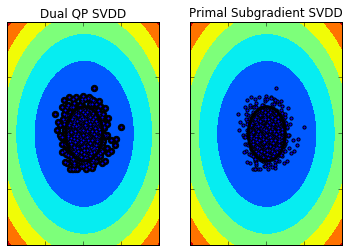

In [15]:
# generate test data grid
delta = 0.1
x = np.arange(-2.0-delta, 2.0+delta, delta)
y = np.arange(-2.0-delta, 2.0+delta, delta)
X, Y = np.meshgrid(x, y)
(sx, sy) = X.shape
Xf = np.reshape(X,(1, sx*sy))
Yf = np.reshape(Y,(1, sx*sy))
Dtest = np.append(Xf, Yf, axis=0)
if Dtrain.shape[0] > 2:
    Dtest = np.append(Dtest, np.random.randn(Dtrain.shape[0]-2, sx*sy), axis=0)
print(Dtest.shape)

res = svdd.predict(Dtest)
pres = psvdd.predict(Dtest)

# nice visualization
plt.figure(1)
plt.subplot(1, 2, 1)
plt.title('Dual QP SVDD')
Z = np.reshape(res,(sx, sy))
plt.contourf(X, Y, Z)
plt.contour(X, Y, Z, [0.0], linewidths=3.0, colors='k')
plt.scatter(Dtrain[0, svdd.get_support_inds()], Dtrain[1, svdd.get_support_inds()], 40, c='k')
plt.scatter(Dtrain[0, :], Dtrain[1, :],10)
plt.xlim((-2., 2.))
plt.ylim((-2., 2.))
plt.yticks(range(-2, 2), [])
plt.xticks(range(-2, 2), [])

plt.subplot(1, 2, 2)
plt.title('Primal Subgradient SVDD')
Z = np.reshape(pres,(sx, sy))
plt.contourf(X, Y, Z)
plt.contour(X, Y, Z, [0.0], linewidths=3.0, colors='k')
plt.scatter(Dtrain[0, :], Dtrain[1, :], 10)
plt.xlim((-2., 2.))
plt.ylim((-2., 2.))
plt.yticks(range(-2, 2), [])
plt.xticks(range(-2, 2), [])

plt.show()